# XRF Monte-carlo simulations

In [1]:
from spectrocrunch.materials import multilayer
from spectrocrunch.materials import compoundfromformula
from spectrocrunch.materials import compoundfromdb
from spectrocrunch.materials import compoundfromlist
from spectrocrunch.materials import element
from spectrocrunch.materials import mixture
from spectrocrunch.materials import types
from spectrocrunch.materials import xrfstandards
from spectrocrunch.sources import xray as xraysources
from spectrocrunch.materials import pymca
from spectrocrunch.detectors import xrf as xrfdetectors
from spectrocrunch.geometries import xrf as xrfgeometries
from spectrocrunch.io.utils import mkdir
import matplotlib.pyplot as plt
import numpy as np


def addnoise(cts):
    return np.random.poisson(np.round(cts).astype(int))

In [2]:
def define_geometry(source="synchrotron", detector="leia", geometry="sxm120"):
    source = xraysources.factory(source)
    detector = xrfdetectors.factory(detector)
    return xrfgeometries.factory(geometry, detector=detector, source=source)


def define_setup(
    sample, energy=7.5, flux=1e10, time=0.1, escape=True, pileup=True, ninteractions=1
):
    return pymca.PymcaHandle(
        energy=energy,
        flux=flux,
        time=time,
        ninteractions=ninteractions,
        escape=escape,
        pileup=pileup,
        linear=True,
        snip=False,
        scatter=True,
        sample=sample,
    )

In [3]:
# All pre-defined compounds:
# print(compoundfromdb.getnames())
# Search in pre-defined compounds:
# print(compoundfromdb.search('ferric'))


def define_sample(geometry, name=None):
    if name == "cell":
        cell = compoundfromdb.compoundfromdb("ecoli dry")
        substrate = compoundfromdb.compoundfromdb("silicon nitride")
        # Dope cell with elements (1e-6 = 1 ppm)
        cell.addelements(["Ce"], [100e-6], types.fraction.mole)
        # Add sample cover
        ultralene = compoundfromdb.compoundfromdb("ultralene")
        attenuators = [
            ["SampleCover", ultralene, 4.064e-4],
            ["BeamFilter0", ultralene, 4.064e-4],
        ]
        for k in attenuators:
            geometry.addattenuator(*k)
        # Multilayer of cell on substrate
        sample = multilayer.Multilayer(
            material=[cell, substrate],
            thickness=[10e-4, 0.2e-4],
            geometry=geometry,
            name="cell",
        )
    elif name == "plant":
        plant = compoundfromdb.compoundfromdb("Cellulose Nitrate")
        # Dope cell with elements (1e-6 = 1 ppm)
        elements = ["Ce", "P", "S", "Cl", "K", "Ca", "Mn", "Fe"]
        mfracs = [200e-6, 2000e-6, 1000e-6, 100e-6, 10000e-6, 5000e-6, 50e-6, 100e-6]
        plant.addelements(elements, mfracs, types.fraction.mole)
        # Add sample cover
        ultralene = compoundfromdb.compoundfromdb("ultralene")
        attenuators = [
            ["SampleCover", ultralene, 4.064e-4],
            ["BeamFilter0", ultralene, 4.064e-4],
        ]
        for k in attenuators:
            geometry.addattenuator(*k)
        # Multilayer of cell on substrate
        sample = multilayer.Multilayer(
            material=[plant, ultralene],
            thickness=[20e-4, 4.064e-4],
            geometry=geometry,
            name="plant",
        )
    elif name == "axo":
        sample = xrfstandards.factory(
            "id21_room",
            geometry=geometry,
            filmthickness=1e-7,
            extraelements=["Ni", "Cl", "Cr", "Al"],
        )
    else:
        c1 = compoundfromdb.compoundfromdb("hematite")
        c2 = compoundfromformula.CompoundFromFormula("PbSO4", density=6.29)
        c3 = compoundfromlist.CompoundFromList(
            ["Ca", "C", "O"],
            [1, 1, 3],
            types.fraction.mole,
            density=2.71,
            name="calcite",
        )
        homogen = mixture.Mixture(
            [c1, c2, c3], [1, 1, 1], types.fraction.mass, name="mixture"
        )
        # xmimisim cannot handle mixtures of compounds
        homogen = homogen.tocompound()
        sample = multilayer.Multilayer(
            material=[c3], thickness=[30e-4], geometry=geometry, name="simple"
        )
    return sample

In [5]:
geometry = define_geometry()

# Customize geometry
# geometry.distance=5
# geometry.detector.thickness=1e-4
# geometry.anglein = 90
# geometry.angleout = 45
# geometry.detector_azimuth = 0
# geometry.sample_azimuth = 180

# material = element.Element("Si")
# geometry.detector.addbeamfilter(None, material, 10e-4)

geometry.detector.removedetectorfilters()
material = element.Element("Be")
geometry.detector.adddetectorfilter("Be", material, 50e-4)
material = compoundfromdb.compoundfromdb("ultralene")
geometry.detector.adddetectorfilter("ultralene", material, 1e-10)

sample = define_sample(geometry, name="simple")
setup = define_setup(sample, energy=7.5, flux=1e10, time=0.1, ninteractions=1)
setup.emin = 1
setup.emax = 8.49
print(setup)

spectrum1 = setup.xrayspectrum(method="calculation")
spectrum2 = setup.xrayspectrum(method="fisx", scattering=False)
spectrum3 = setup.xrayspectrum(method="xrmc")
spectrum4 = setup.xrayspectrum(method="xmimsim")
spectrum5 = setup.xrayspectrum(method="xmimsim", runxrmc=True)

Flux = 1.000000e+10 Hz
Time = 0.1 s
Source lines:
 7.5 keV: 100.0 % (Scatter: 1.0)
Multilayer (ordered top-bottom):
 Layer 0. 30.0 um (calcite)
XraySource:
 intensity = 0.9999999999999998 (W/m^2)
 dop = 1.0
 dolp = 1.0
 polangle = 0.0 (deg)
 handedness = none
XRF detector:
 Active area = 0.8 cm ** 2
 Ionization energy = 3.6685605263157894 eV
 Material = Si (0.045 cm)
Beam filters: None
Detector filters:
 Be = 0.005 cm
 ultralene = 1e-10 cm
MCA:
 zero = 0.0 eV
 gain = 5.0 eV
 noise = 50.0 eV (FWHM)
 fano = 0.19
Geometry:
 In = 62 deg
 Out = 58 deg (reflection)
 Sample azimuth = 180 deg
 Detector azimuth = 0 deg
 Distance = 57.0 mm
 Solid angle = 4*pi*0.0019479895562839467 srad
 Detector position = 0 mm


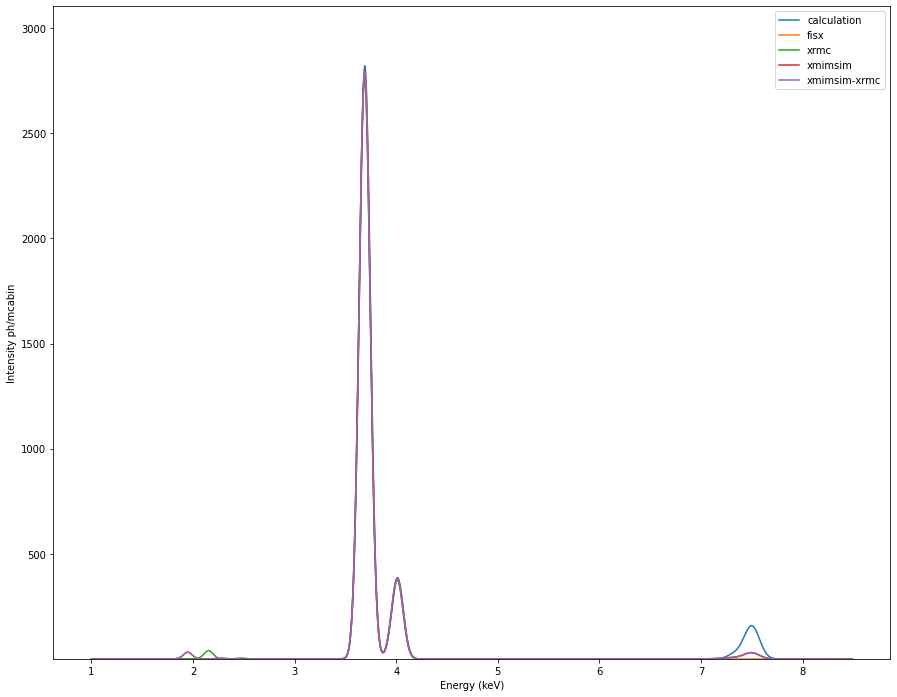

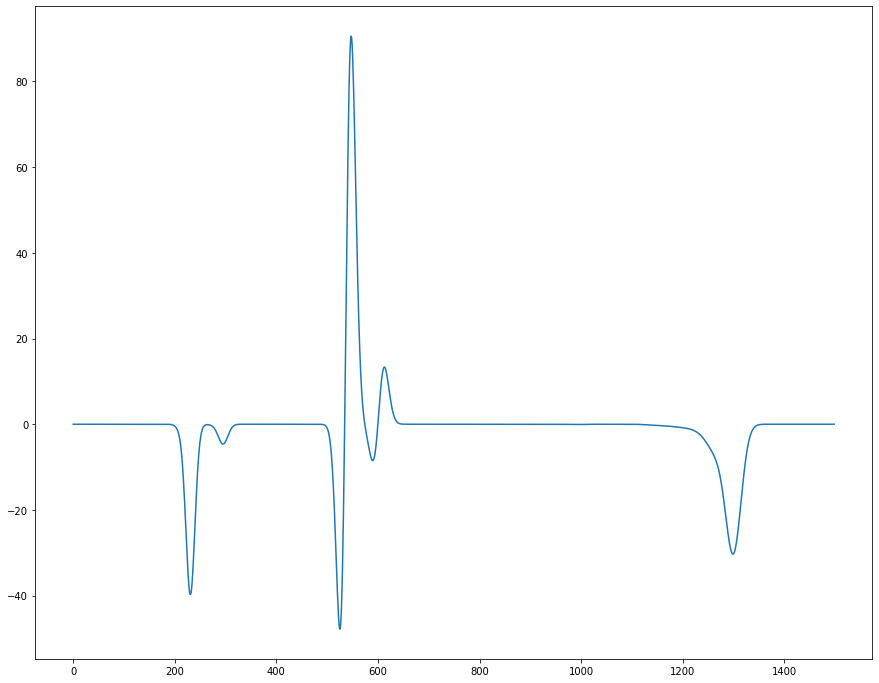

In [6]:
plt.figure(figsize=(15, 12))
# spectrum1.plot(decompose=False, histogram=True, fluxtime=setup.I0, sumlabel='calculation')
# spectrum2.plot(decompose=False, histogram=True, fluxtime=setup.I0, sumlabel='fisx')
# spectrum3.plot(decompose=False, histogram=True, fluxtime=setup.I0, sumlabel='xrmc')
# spectrum4.plot(decompose=False, histogram=True, fluxtime=setup.I0, sumlabel='xmimsim')
# spectrum5.plot(decompose=False, histogram=True, fluxtime=setup.I0, sumlabel='xmimsim-xrmc')

x1, y1, ylabel = spectrum1.sumspectrum(histogram=True, fluxtime=setup.I0)
x2, y2, ylabel = spectrum2.sumspectrum(histogram=True, fluxtime=setup.I0)
x3, y3, ylabel = spectrum3.sumspectrum(histogram=True, fluxtime=setup.I0)
x4, y4, ylabel = spectrum4.sumspectrum(histogram=True, fluxtime=setup.I0)
x5, y5, ylabel = spectrum5.sumspectrum(histogram=True, fluxtime=setup.I0)
# y1 = addnoise(y1)

plt.plot(x1, y1, label="calculation")
plt.plot(x2, y2, label="fisx")
plt.plot(x3, y3, label="xrmc")
plt.plot(x3, y4, label="xmimsim")
plt.plot(x3, y4, label="xmimsim-xrmc")

ax = plt.gca()
# ax.set_yscale('log', base=10)
ax.set_ylim(bottom=0.9, top=max([y1.max(), y2.max(), y3.max(), y4.max()]) * 1.1)
ax.set_ylabel(ylabel)
ax.set_xlabel("Energy (keV)")
plt.legend()

plt.figure(figsize=(15, 12))
tmp = plt.plot(y2 - y3, label="fisx - xmimsim")